# 手把手教你构建深度学习网络

**目标：**
* 构建不止一个隐藏层的神经网络
* 学会使用 relu激活函数 的反向传播


## 1.导入需要的库、数据


In [1]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt

from data.read_cat_data import load_dataset   # 使用猫咪的样本训练

%matplotlib inline

np.random.seed(1)  # 指定随机数种子，这样得到的权重啥的每次都不会变

In [2]:
# 数据处理成一维，以及数据标准化（除以255）
train_set_x_orig, Y, test_set_x_orig, test_Y, classes = load_dataset()

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(Y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_Y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

X = train_set_x_flatten / 255
test_X = test_set_x_flatten / 255

train_set_x_flatten shape: (12288, 2005)
train_set_y shape: (1, 2005)
test_set_x_flatten shape: (12288, 503)
test_set_y shape: (1, 503)
sanity check after reshaping: [247 255 255 247 255]


## 2 - 任务大纲
**整体大纲：**
* 参数初始化
* 前向传播（线性传播，线性激活传播，L层Model前向传播）
* cost function
* 反向传播（线性反向传播，线性激活反向传播，L层model反向传播，更新参数）
* 组合成 deep_model

## 3 - 初始化

### 3.1 - 2层神经网络的参数初始化（回顾）

In [3]:
def initialize_parameters(n_x, n_h, n_y):
    
    W1 = np.random.randn(n_h, n_x) * 0.1
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.1
    b2 = np.zeros((n_y, 1))
    
    return {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2
    }

In [4]:
params = initialize_parameters(8, 6, 1)
print(params)

{'W1': array([[ 0.16646511,  0.14747135, -0.13570815, -0.05913316,  0.03489697,
        -0.00833146, -0.25781995, -0.04803664],
       [ 0.11777694,  0.02135236, -0.00233068, -0.15091276,  0.10504432,
        -0.09289275, -0.00861066,  0.13947749],
       [ 0.02233249, -0.21169258, -0.02075255, -0.06162985, -0.08799015,
         0.05994466, -0.09889946,  0.00402043],
       [-0.05041846, -0.06789399, -0.24089803, -0.21682049,  0.12259785,
        -0.12606845,  0.04666415, -0.08931865],
       [ 0.01085673,  0.00641558,  0.00067795,  0.00222711, -0.10430364,
        -0.06029706, -0.00221706,  0.04670966],
       [ 0.17226361,  0.06064418,  0.00476993, -0.03146223,  0.09372917,
         0.13075614,  0.03422094, -0.01267362]]), 'b1': array([[ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]]), 'W2': array([[ 0.04167452, -0.10606481, -0.04439935,  0.10487268,  0.0753599 ,
        -0.02258624]]), 'b2': array([[ 0.]])}


## 3.2 - L-layer size model

$$size(W^{[L]}) = (dim(L), dim(L - 1))$$
$$size(b^{[L]}) = (dim(L), 1)$$

In [25]:
def initilize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for i in range(1, L):
        parameters["W" + str(i)] = np.random.randn(layer_dims[i], layer_dims[i - 1]) * 0.01
        parameters["b" + str(i)] = np.zeros((layer_dims[i], 1))
    return parameters

## 4 - 前向传播模型

### 4.1 - 前向线性传播

$$Z^{[l]} = W^{[l]}A^{[l - 1]} + b^{[l]}$$

In [6]:
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)
    return Z, linear_cache

### 4.2 - 线性激活前向传播

使用一下两种激活函数：
* **Sigmoid**:$\sigma(Z) = \sigma(WA + b) = \frac{1}{1 + e^{-(WA + b)}}$
* **ReLu**: $A = max(0, Z)$

In [7]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, {
        "Z" : Z,
        "A" : A
    }

def relu(Z):
    A = np.maximum(0,Z)
    return A, {
        "Z": Z,
        "A": A
    }

def linear_activition_forward(A_prev, W, b, activition):
    if activition == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activition_cache = sigmoid(Z)
    elif activition == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activition_cache = relu(Z)
    cache = (linear_cache, activition_cache)
    return A, cache

**实现 L-layer 模型的前向传播：**

In [8]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2 # parameters 长度的一般是层的数量（不包括输入层）
    for l in range(1, L + 1):
        A_prev = A
        if l == L:
            activition = 'sigmoid'
        else:
            activition = 'relu'
            
        A, cache = linear_activition_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activition)
        
        caches.append(cache)
    
    AL = A
#     assert(AL.shape == (1,X.shape[1]))
    
    return AL, caches


## 5 - 计算 cost funciton

In [9]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = - (np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))) / m
    cost = np.squeeze(cost)
    return cost

## 6 - 反向传播模型

为了实现反向传播，首先要构造三个反向传播函数：

* 线性反向传播 linear backward
* ReLu 线性激活反向传播 relu backward
* Sigmoid 线性激活反向传播 sigmoid backward

### 6.1 - 线性反向传播

由 $$Z^{[l]} = W^{[l]}A^{[l - 1]} + b^{[l]}$$

得 $$dA^{[l - 1]} = W^{[1]T}dZ^{[1]}$$
$$dW^{[l]} = \frac{1}{m} dZ^{[l]}A^{[l-1]T}$$
$$db^{[l]} = np.sum(dZ^{[l]}, axis=1, keepdims=True)$$

In [22]:
def linear_backward(dZ, linear_cache):
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ, A_prev.T) / m
    dA_prev = np.dot(W.T, dZ)
    db = np.sum(dZ, axis=1, keepdims=True) / m
    
    return dA_prev, dW, db


### 6.2 - 线性激活反向传播

为了实现**linear_activition_backward**，首先要实现以下两个函数：
* **sigmoid_backward** `dZ = sigmoid_backward(dA, activition_cache)`
* **relu_backward** `dZ = relu_backward(dA, activition_cache)`

In [ ]:
def sigmoid_backward(dA, activition_cache):
    Z = activition_cache['Z']

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

def relu_backward(dA, activition_cache):
    Z = activition_cache['Z']
    
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0

    return dZ

def linear_activition_backward(dA, cache, activition):
    linear_cache, activition_cache = cache
    
    if activition == 'relu':
        dZ = relu_backward(dA, activition_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activition == 'sigmoid':
        dZ = sigmoid_backward(dA, activition_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


### 6.3 - L-layer 反向传播，求梯度 grads

根据 loss 公式，求 $dA^{[L]} = - \frac{Y}{AL} - \frac{1-Y}{1-AL}$

In [12]:
def L_layer_model(AL, Y, caches):
    grads = {}
    
    L = len(caches) # 层数（不包括输入层）
    m = Y.shape[1]
    
    dAL = -np.divide(Y, AL) - np.divide(1-Y, 1-AL)
    
    current_cache = caches[L - 1]
    grads['dA' + str(L - 1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activition_backward(dAL, current_cache, 'sigmoid')
    
    for l in reversed(range(1, L)):
        current_cache = caches[l - 1]
        grads['dA' + str(l - 1)], grads['dW' + str(l)], grads['db' + str(l)] = linear_activition_backward(grads['dA' + str(l)], current_cache, 'relu')
    
    return grads

### 6.4 - 更新参数


In [13]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network
    # Update rule for each parameter. Use a for loop.
#     print(parameters)
#     print(grads)
    ### START CODE HERE ### (≈ 3 lines of code)
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    
    ### END CODE HERE ###
    return parameters

## 7 - 合并成 deep_nn_model

In [19]:
def deep_nn_model(X, Y, layer_dims, learning_rate=0.5, num_iterations=2000, print_cost=False):
    parameters = initilize_parameters_deep(layer_dims)
    
    costs = []
    for i in range(num_iterations + 1):
        AL, caches = L_model_forward(X, parameters)
        grads = L_layer_model(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        if i % 20 == 0:
            cost = compute_cost(AL, Y)
            costs.append(cost)
            if print_cost:
                print("迭代 %d 次后" % (i), "cost: %f" % cost)
    
    return parameters, costs

迭代 0 次后 cost: 0.693274
迭代 20 次后 cost: 0.692872
迭代 40 次后 cost: 0.692471
迭代 60 次后 cost: 0.692072
迭代 80 次后 cost: 0.691675
迭代 100 次后 cost: 0.691279
迭代 120 次后 cost: 0.690884
迭代 140 次后 cost: 0.690491
迭代 160 次后 cost: 0.690100
迭代 180 次后 cost: 0.689710
迭代 200 次后 cost: 0.689321
迭代 220 次后 cost: 0.688933
迭代 240 次后 cost: 0.688546
迭代 260 次后 cost: 0.688161
迭代 280 次后 cost: 0.687776
迭代 300 次后 cost: 0.687392
迭代 320 次后 cost: 0.687009
迭代 340 次后 cost: 0.686627
迭代 360 次后 cost: 0.686245
迭代 380 次后 cost: 0.685864
迭代 400 次后 cost: 0.685484
迭代 420 次后 cost: 0.685103
迭代 440 次后 cost: 0.684724
迭代 460 次后 cost: 0.684344
迭代 480 次后 cost: 0.683965
迭代 500 次后 cost: 0.683586
迭代 520 次后 cost: 0.683207
迭代 540 次后 cost: 0.682828
迭代 560 次后 cost: 0.682449
迭代 580 次后 cost: 0.682070
迭代 600 次后 cost: 0.681691
迭代 620 次后 cost: 0.681312
迭代 640 次后 cost: 0.680932
迭代 660 次后 cost: 0.680552
迭代 680 次后 cost: 0.680171
迭代 700 次后 cost: 0.679790
迭代 720 次后 cost: 0.679408
迭代 740 次后 cost: 0.679025
迭代 760 次后 cost: 0.678641
迭代 780 次后 cost: 0.678257
迭代 800

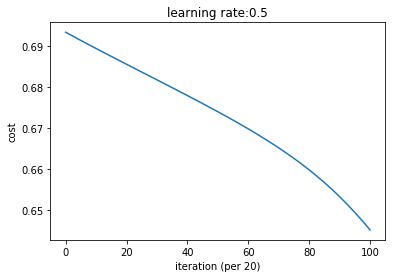

In [29]:
np.seterr(divide='ignore', invalid='ignore')
# 注意 learning rate 的大小选择，有可能太大导致以后的计算结果变成 nan
parameters, costs = deep_nn_model(X, Y, [12288, 192, 24, 1], 0.0002, 2000, True)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iteration (per 20)')
plt.title('learning rate:' + str(0.5))
plt.show()